In [1]:
from tqdm import tqdm
import time
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
import datetime as dt
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.facecolor'] = 'white'
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)



Check for nan - drop primary type nan for end graph at end

# Loading Data

In [2]:
folder = "Data/Chicago/"
crime_files = sorted(glob.glob(folder+"*.csv"))
chicago_df = pd.concat([pd.read_csv(f) for f in crime_files])
chicago_df

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708
1,12259387,01/01/2021 01:00:00 AM,ASSAULT,SIMPLE,GAS STATION,False,False,311,3.0,20.0,41.779998,-87.629295
2,12259526,01/01/2021 01:00:00 AM,ROBBERY,AGGRAVATED,SIDEWALK,False,False,1024,10.0,22.0,41.847145,-87.713645
3,12259461,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,624,6.0,6.0,41.755932,-87.611409
4,12260596,01/01/2021 01:00:00 AM,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,APARTMENT,False,False,2533,25.0,37.0,41.903649,-87.745987
...,...,...,...,...,...,...,...,...,...,...,...,...
123545,13124429,06/30/2023 12:50:00 AM,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,1925,19.0,46.0,41.949093,-87.643737
123546,13124821,06/30/2023 12:50:00 PM,THEFT,RETAIL THEFT,TAVERN / LIQUOR STORE,False,False,1924,19.0,44.0,41.939906,-87.654410
123547,13124281,06/30/2023 12:52:00 AM,SEX OFFENSE,PUBLIC INDECENCY,STREET,False,False,2534,25.0,36.0,41.909763,-87.735792
123548,13124301,06/30/2023 12:57:00 AM,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,832,8.0,18.0,41.761952,-87.684388


# Chicago Dataframe

## test_date

In [3]:
test_date = chicago_df.loc[0, 'Date']
test_date



0    01/01/2021 01:00:00 PM
0    01/01/2022 01:00:00 AM
0    01/01/2023 01:00:00 PM
Name: Date, dtype: object

In [4]:
test_datetime = pd.to_datetime(test_date)
test_datetime

0   2021-01-01 13:00:00
0   2022-01-01 01:00:00
0   2023-01-01 13:00:00
Name: Date, dtype: datetime64[ns]

## Data

In [5]:
chicago_df['CrimeDateTime'] = pd.to_datetime(chicago_df['Date'], format="%m/%d/%Y %H:%M:%S %p")

In [6]:
chicago_df = chicago_df.sort_values('CrimeDateTime')
chicago_df = chicago_df.set_index('CrimeDateTime')
chicago_df.info()
chicago_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570913 entries, 2021-01-01 01:00:00 to 2023-06-30 12:58:00
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    570913 non-null  int64  
 1   Date                  570913 non-null  object 
 2   Primary Type          570913 non-null  object 
 3   Description           570913 non-null  object 
 4   Location Description  568685 non-null  object 
 5   Arrest                570913 non-null  bool   
 6   Domestic              570913 non-null  bool   
 7   Beat                  570913 non-null  int64  
 8   District              570913 non-null  float64
 9   Ward                  570890 non-null  float64
 10  Latitude              558794 non-null  float64
 11  Longitude             558794 non-null  float64
dtypes: bool(2), float64(4), int64(2), object(4)
memory usage: 49.0+ MB


,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
CrimeDateTime,,,,,,,,,,,,
2021-01-01 01:00:00,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708
2021-01-01 01:00:00,12258637,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,False,323,3.0,6.0,41.761108,-87.621595
2021-01-01 01:00:00,12258531,01/01/2021 01:00:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - PORCH / HALLWAY,False,False,1032,10.0,22.0,41.837774,-87.712169
2021-01-01 01:00:00,12258976,01/01/2021 01:00:00 PM,BATTERY,AGGRAVATED OF AN UNBORN CHILD,STREET,False,True,1024,10.0,24.0,41.852538,-87.711171
2021-01-01 01:00:00,12260487,01/01/2021 01:00:00 PM,THEFT,OVER $500,STREET,False,False,2431,24.0,49.0,42.007171,-87.663703


In [7]:
## Extracting the Month
chicago_df['Year'] = chicago_df.index.year
chicago_df.head(3)

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Year
CrimeDateTime,,,,,,,,,,,,,
2021-01-01 01:00:00,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708,2021
2021-01-01 01:00:00,12258637,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,False,323,3.0,6.0,41.761108,-87.621595,2021
2021-01-01 01:00:00,12258531,01/01/2021 01:00:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - PORCH / HALLWAY,False,False,1032,10.0,22.0,41.837774,-87.712169,2021


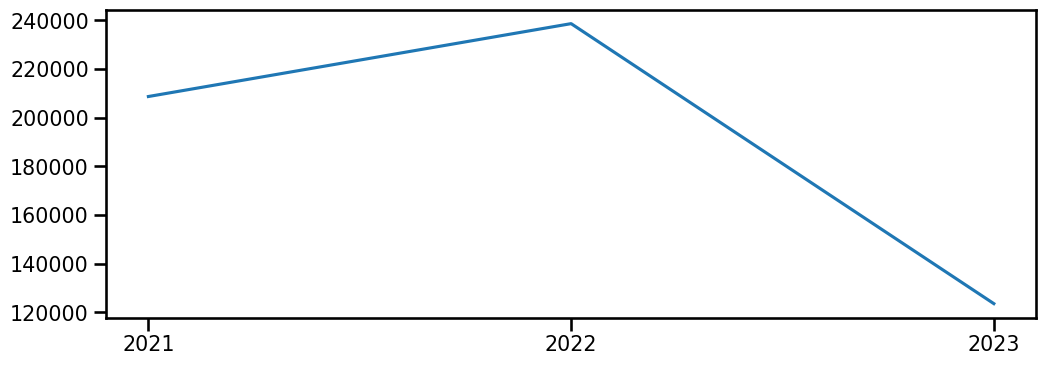

In [8]:
#viewing the crimes each year sum
years = chicago_df.index.year
ax = years.value_counts().sort_index().plot(kind='line');
ax.set_xticks([2021, 2022, 2023])
plt.savefig("Data/Crimes_Each_Year")

- During Covid times in Chicago, in 2021, the crime count was over 200,000, then spikes in the year 2022 to over 240,000 and decreases majorly in 2023.
- In the year 2023 more things were opening up and more people were out and about, leaving less time for criminal activity and more time for freedom!


In [9]:
## Inspecting the value_counts for the different types of crimes
crime_counts = chicago_df['Primary Type'].value_counts()
crime_counts.sort_values()


OTHER NARCOTIC VIOLATION                 11
NON-CRIMINAL                             11
PUBLIC INDECENCY                         12
GAMBLING                                 26
HUMAN TRAFFICKING                        32
OBSCENITY                               117
KIDNAPPING                              266
CONCEALED CARRY LICENSE VIOLATION       441
INTIMIDATION                            443
LIQUOR LAW VIOLATION                    485
PROSTITUTION                            500
INTERFERENCE WITH PUBLIC OFFICER        992
STALKING                               1034
ARSON                                  1194
PUBLIC PEACE VIOLATION                 1735
HOMICIDE                               1839
SEX OFFENSE                            2926
CRIMINAL SEXUAL ASSAULT                3801
OFFENSE INVOLVING CHILDREN             4730
CRIMINAL TRESPASS                      9942
NARCOTICS                             12466
BURGLARY                              17819
ROBBERY                         

In [10]:
## Inspect the value_counts for the different types of crimes
crime_counts = chicago_df['Primary Type'].value_counts().to_frame('Total # of Crimes')
crime_counts


,Total # of Crimes
THEFT,121875
BATTERY,102360
CRIMINAL DAMAGE,66574
ASSAULT,51891
MOTOR VEHICLE THEFT,46566
DECEPTIVE PRACTICE,41376
OTHER OFFENSE,36048
WEAPONS VIOLATION,22052
ROBBERY,21349
BURGLARY,17819


In [11]:
# comparing
## demoing groupby with .size()
chicago_df.groupby("Primary Type").size()



Primary Type
ARSON                                  1194
ASSAULT                               51891
BATTERY                              102360
BURGLARY                              17819
CONCEALED CARRY LICENSE VIOLATION       441
CRIMINAL DAMAGE                       66574
CRIMINAL SEXUAL ASSAULT                3801
CRIMINAL TRESPASS                      9942
DECEPTIVE PRACTICE                    41376
GAMBLING                                 26
HOMICIDE                               1839
HUMAN TRAFFICKING                        32
INTERFERENCE WITH PUBLIC OFFICER        992
INTIMIDATION                            443
KIDNAPPING                              266
LIQUOR LAW VIOLATION                    485
MOTOR VEHICLE THEFT                   46566
NARCOTICS                             12466
NON-CRIMINAL                             11
OBSCENITY                               117
OFFENSE INVOLVING CHILDREN             4730
OTHER NARCOTIC VIOLATION                 11
OTHER OFFENSE      

In [12]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570913 entries, 2021-01-01 01:00:00 to 2023-06-30 12:58:00
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    570913 non-null  int64  
 1   Date                  570913 non-null  object 
 2   Primary Type          570913 non-null  object 
 3   Description           570913 non-null  object 
 4   Location Description  568685 non-null  object 
 5   Arrest                570913 non-null  bool   
 6   Domestic              570913 non-null  bool   
 7   Beat                  570913 non-null  int64  
 8   District              570913 non-null  float64
 9   Ward                  570890 non-null  float64
 10  Latitude              558794 non-null  float64
 11  Longitude             558794 non-null  float64
 12  Year                  570913 non-null  int64  
dtypes: bool(2), float64(4), int64(3), object(4)
memory usage: 53.4+ MB


# Holiday Dataframe 

In [13]:
import holidays
from holidays import country_holidays

In [14]:
## making a date range that covers full dataset
all_days = pd.date_range(chicago_df["Date"].min(), chicago_df["Date"].max())
all_days

DatetimeIndex(['2021-01-01 01:00:00', '2021-01-02 01:00:00',
               '2021-01-03 01:00:00', '2021-01-04 01:00:00',
               '2021-01-05 01:00:00', '2021-01-06 01:00:00',
               '2021-01-07 01:00:00', '2021-01-08 01:00:00',
               '2021-01-09 01:00:00', '2021-01-10 01:00:00',
               ...
               '2022-12-22 01:00:00', '2022-12-23 01:00:00',
               '2022-12-24 01:00:00', '2022-12-25 01:00:00',
               '2022-12-26 01:00:00', '2022-12-27 01:00:00',
               '2022-12-28 01:00:00', '2022-12-29 01:00:00',
               '2022-12-30 01:00:00', '2022-12-31 01:00:00'],
              dtype='datetime64[ns]', length=730, freq='D')

In [15]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [16]:
## Testing first date
print(all_days[0])
us_holidays.get(all_days[0])

2021-01-01 01:00:00


"New Year's Day"

In [17]:
## Getting us holidays for all dates
holiday_list = [us_holidays.get(day) for day in all_days]
holiday_list[:5]

["New Year's Day", None, None, None, None]

In [18]:
# For a specific subdivisions (e.g. state or province):
co_holidays = country_holidays('US', subdiv='CO')
co_holidays

holidays.country_holidays('US', subdiv='CO')

In [19]:
## Saving both holiday types as columns
chicago_df["US Holiday"] = [us_holidays.get(day) for day in chicago_df['Date']]
chicago_df['CO Holiday'] = [co_holidays.get(day) for day in chicago_df['Date']]
chicago_df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Year,US Holiday,CO Holiday
CrimeDateTime,,,,,,,,,,,,,,,
2021-01-01 01:00:00,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708,2021,New Year's Day,New Year's Day
2021-01-01 01:00:00,12258637,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,False,323,3.0,6.0,41.761108,-87.621595,2021,New Year's Day,New Year's Day
2021-01-01 01:00:00,12258531,01/01/2021 01:00:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - PORCH / HALLWAY,False,False,1032,10.0,22.0,41.837774,-87.712169,2021,New Year's Day,New Year's Day
2021-01-01 01:00:00,12258976,01/01/2021 01:00:00 PM,BATTERY,AGGRAVATED OF AN UNBORN CHILD,STREET,False,True,1024,10.0,24.0,41.852538,-87.711171,2021,New Year's Day,New Year's Day
2021-01-01 01:00:00,12260487,01/01/2021 01:00:00 PM,THEFT,OVER $500,STREET,False,False,2431,24.0,49.0,42.007171,-87.663703,2021,New Year's Day,New Year's Day


In [20]:
## US Holidays
chicago_df['US Holiday'].value_counts()

New Year's Day                                     2476
Juneteenth National Independence Day               2163
Memorial Day                                       1996
Martin Luther King Jr. Day                         1638
Washington's Birthday                              1508
Juneteenth National Independence Day (Observed)    1402
Independence Day                                   1401
Labor Day                                          1361
Veterans Day                                       1346
Columbus Day                                       1281
New Year's Day (Observed)                          1254
Thanksgiving                                        980
Christmas Day (Observed)                            949
Christmas Day                                       881
Independence Day (Observed)                         674
Name: US Holiday, dtype: int64

In [21]:
## CO Holidays
chicago_df['CO Holiday'].value_counts()

New Year's Day                                     2476
Juneteenth National Independence Day               2163
Memorial Day                                       1996
Martin Luther King Jr. Day                         1638
Washington's Birthday                              1508
Juneteenth National Independence Day (Observed)    1402
Independence Day                                   1401
Labor Day                                          1361
Veterans Day                                       1346
Columbus Day                                       1281
New Year's Day (Observed)                          1254
Thanksgiving                                        980
Christmas Day (Observed)                            949
Christmas Day                                       881
Independence Day (Observed)                         674
Name: CO Holiday, dtype: int64

# Resampled Dataframe

In [22]:
## Creating a Total # of Crimes
# getting list of  unique crime descriptions
crime_list = chicago_df['Primary Type'].unique()
crime_list

array(['ASSAULT', 'BATTERY', 'WEAPONS VIOLATION', 'THEFT',
       'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'CRIMINAL DAMAGE',
       'DECEPTIVE PRACTICE', 'ROBBERY', 'PUBLIC PEACE VIOLATION',
       'CRIMINAL SEXUAL ASSAULT', 'NARCOTICS', 'OTHER OFFENSE',
       'BURGLARY', 'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE',
       'HOMICIDE', 'INTERFERENCE WITH PUBLIC OFFICER',
       'CONCEALED CARRY LICENSE VIOLATION', 'PROSTITUTION',
       'HUMAN TRAFFICKING', 'OBSCENITY', 'STALKING', 'ARSON',
       'LIQUOR LAW VIOLATION', 'KIDNAPPING', 'INTIMIDATION',
       'PUBLIC INDECENCY', 'NON-CRIMINAL', 'GAMBLING',
       'OTHER NARCOTIC VIOLATION'], dtype=object)

In [23]:
# Creating an empty dictionary  
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
   temp = chicago_df.loc[chicago_df['Primary Type']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("D").size() 
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
CRIMES.keys()

dict_keys(['ASSAULT', 'BATTERY', 'WEAPONS VIOLATION', 'THEFT', 'CRIMINAL TRESPASS', 'MOTOR VEHICLE THEFT', 'CRIMINAL DAMAGE', 'DECEPTIVE PRACTICE', 'ROBBERY', 'PUBLIC PEACE VIOLATION', 'CRIMINAL SEXUAL ASSAULT', 'NARCOTICS', 'OTHER OFFENSE', 'BURGLARY', 'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'HOMICIDE', 'INTERFERENCE WITH PUBLIC OFFICER', 'CONCEALED CARRY LICENSE VIOLATION', 'PROSTITUTION', 'HUMAN TRAFFICKING', 'OBSCENITY', 'STALKING', 'ARSON', 'LIQUOR LAW VIOLATION', 'KIDNAPPING', 'INTIMIDATION', 'PUBLIC INDECENCY', 'NON-CRIMINAL', 'GAMBLING', 'OTHER NARCOTIC VIOLATION'])

In [24]:
resampled_df = pd.DataFrame(CRIMES)
resampled_df

,ASSAULT,BATTERY,WEAPONS VIOLATION,THEFT,CRIMINAL TRESPASS,MOTOR VEHICLE THEFT,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,ROBBERY,PUBLIC PEACE VIOLATION,CRIMINAL SEXUAL ASSAULT,NARCOTICS,OTHER OFFENSE,BURGLARY,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,HOMICIDE,INTERFERENCE WITH PUBLIC OFFICER,CONCEALED CARRY LICENSE VIOLATION,PROSTITUTION,HUMAN TRAFFICKING,OBSCENITY,STALKING,ARSON,LIQUOR LAW VIOLATION,KIDNAPPING,INTIMIDATION,PUBLIC INDECENCY,NON-CRIMINAL,GAMBLING,OTHER NARCOTIC VIOLATION
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,39,158,61,76,10,22,94,130,11,5,16,12,65,21,32,10,2,1,2.0,2.0,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,34,84,31,78,8,23,40,54,14,0,2,20,35,16,4,1,1,1,0.0,0.0,0.0,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,33,108,31,70,13,30,73,62,20,3,3,24,20,15,4,2,2,1,0.0,0.0,0.0,0,0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
2021-01-04,38,84,30,87,8,23,54,104,13,1,5,14,35,18,5,5,3,1,0.0,0.0,0.0,1,2,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2021-01-05,39,79,26,93,5,29,62,92,22,4,1,21,32,21,3,1,1,4,1.0,0.0,0.0,0,3,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,54,120,32,189,10,78,99,29,36,6,5,13,73,25,5,6,2,1,0.0,NaN,NaN,0,0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN
2023-06-27,66,112,21,161,11,96,92,25,37,3,6,18,51,18,6,4,3,0,0.0,NaN,NaN,0,3,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2023-06-28,76,96,21,129,16,75,76,17,25,3,3,17,35,18,4,5,2,0,2.0,NaN,NaN,0,2,2.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN


In [25]:
## saving to disk
resampled_df.to_csv("Data/Chicago_crime_counts_resampled.csv")
chicago_df.to_csv("Data/Chicago_crime_counts.csv")

In [26]:
## check our df.index
resampled_df.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-06-21', '2023-06-22', '2023-06-23', '2023-06-24',
               '2023-06-25', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', name='CrimeDateTime', length=911, freq='D')

In [27]:
resampled_df = resampled_df.resample('D').asfreq()
resampled_df.head(3)


,ASSAULT,BATTERY,WEAPONS VIOLATION,THEFT,CRIMINAL TRESPASS,MOTOR VEHICLE THEFT,CRIMINAL DAMAGE,DECEPTIVE PRACTICE,ROBBERY,PUBLIC PEACE VIOLATION,CRIMINAL SEXUAL ASSAULT,NARCOTICS,OTHER OFFENSE,BURGLARY,OFFENSE INVOLVING CHILDREN,SEX OFFENSE,HOMICIDE,INTERFERENCE WITH PUBLIC OFFICER,CONCEALED CARRY LICENSE VIOLATION,PROSTITUTION,HUMAN TRAFFICKING,OBSCENITY,STALKING,ARSON,LIQUOR LAW VIOLATION,KIDNAPPING,INTIMIDATION,PUBLIC INDECENCY,NON-CRIMINAL,GAMBLING,OTHER NARCOTIC VIOLATION
CrimeDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,39,158,61,76,10,22,94,130,11,5,16,12,65,21,32,10,2,1,2.0,2.0,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02,34,84,31,78,8,23,40,54,14,0,2,20,35,16,4,1,1,1,0.0,0.0,0.0,0,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03,33,108,31,70,13,30,73,62,20,3,3,24,20,15,4,2,2,1,0.0,0.0,0.0,0,0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN


In [28]:
ts0 = resampled_df.index[0]
ts0

Timestamp('2021-01-01 00:00:00', freq='D')

In [29]:
## fill null values with 0
crimes_ts = resampled_df.fillna(0)
crimes_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 911 entries, 2021-01-01 to 2023-06-30
Freq: D
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ASSAULT                            911 non-null    int64  
 1   BATTERY                            911 non-null    int64  
 2   WEAPONS VIOLATION                  911 non-null    int64  
 3   THEFT                              911 non-null    int64  
 4   CRIMINAL TRESPASS                  911 non-null    int64  
 5   MOTOR VEHICLE THEFT                911 non-null    int64  
 6   CRIMINAL DAMAGE                    911 non-null    int64  
 7   DECEPTIVE PRACTICE                 911 non-null    int64  
 8   ROBBERY                            911 non-null    int64  
 9   PUBLIC PEACE VIOLATION             911 non-null    int64  
 10  CRIMINAL SEXUAL ASSAULT            911 non-null    int64  
 11  NARCOTICS                      

# Comparing Months:


## What months have the most crime? What months have the least?

In [30]:
## Extracting the Month
chicago_df['Month'] = chicago_df.index.month
chicago_df['MonthName'] = chicago_df.index.month_name()
chicago_df.head(3)



,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Year,US Holiday,CO Holiday,Month,MonthName
CrimeDateTime,,,,,,,,,,,,,,,,,
2021-01-01 01:00:00,12258992,01/01/2021 01:00:00 PM,ASSAULT,SIMPLE,RESIDENCE,False,False,624,6.0,8.0,41.757849,-87.601708,2021,New Year's Day,New Year's Day,1,January
2021-01-01 01:00:00,12258637,01/01/2021 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,False,323,3.0,6.0,41.761108,-87.621595,2021,New Year's Day,New Year's Day,1,January
2021-01-01 01:00:00,12258531,01/01/2021 01:00:00 AM,WEAPONS VIOLATION,RECKLESS FIREARM DISCHARGE,RESIDENCE - PORCH / HALLWAY,False,False,1032,10.0,22.0,41.837774,-87.712169,2021,New Year's Day,New Year's Day,1,January


In [31]:
# saving lookup for number vs name
unique_months = chicago_df.drop_duplicates(subset=['Month']).sort_values('Month')
month_lookup =dict(zip(unique_months['Month'],unique_months['MonthName']))
month_lookup

{1: 'January',
 2: 'February',
 3: 'March',
 4: 'April',
 5: 'May',
 6: 'June',
 7: 'July',
 8: 'August',
 9: 'September',
 10: 'October',
 11: 'November',
 12: 'December'}

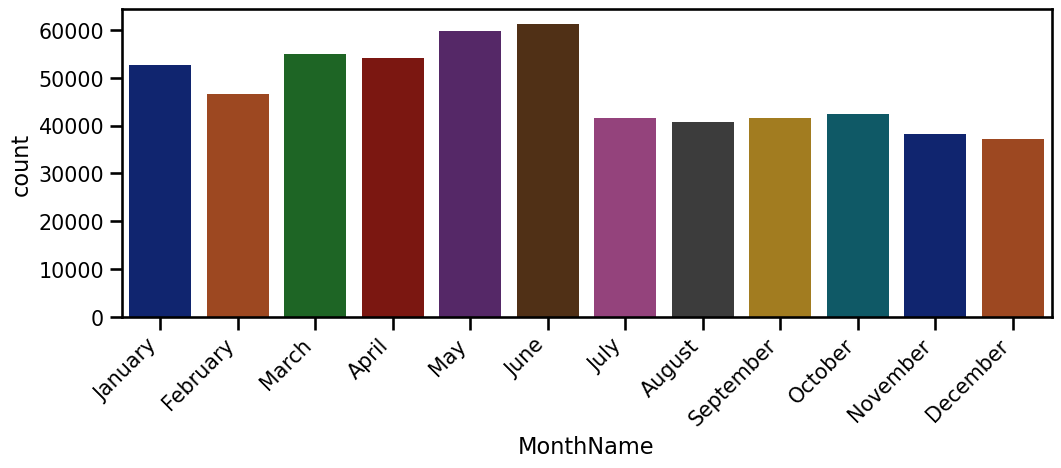

In [45]:
ax = sns.countplot(data=chicago_df, x='MonthName',palette='dark',order=month_lookup.values());
# Rotate xtick labels and align the text to the bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
plt.savefig("Data/Monthly Crimes in Chicago.png", dpi=300, bbox_inches='tight')
plt.show()

- Most crimes are in June at about 60,000, a slight difference between it's runner up, May. 
- The least amount of crimes are in December at by half around 30,000.

## Are there any individual crimes that do not follow this pattern? If so, which crimes?

In [33]:
chicago_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 570913 entries, 2021-01-01 01:00:00 to 2023-06-30 12:58:00
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    570913 non-null  int64  
 1   Date                  570913 non-null  object 
 2   Primary Type          570913 non-null  object 
 3   Description           570913 non-null  object 
 4   Location Description  568685 non-null  object 
 5   Arrest                570913 non-null  bool   
 6   Domestic              570913 non-null  bool   
 7   Beat                  570913 non-null  int64  
 8   District              570913 non-null  float64
 9   Ward                  570890 non-null  float64
 10  Latitude              558794 non-null  float64
 11  Longitude             558794 non-null  float64
 12  Year                  570913 non-null  int64  
 13  US Holiday            21310 non-null   object 
 14  CO Holiday        

In [34]:
crime_by_mos = chicago_df.groupby("Primary Type")['MonthName'].value_counts().to_frame('crime_count')
crime_by_mos

crime_count
Primary Type      MonthName             
ARSON             May                145
                  June               133
                  April              111
                  January            111
                  March              101
...                                  ...
WEAPONS VIOLATION August            1628
                  September         1589
                  October           1474
                  November          1295
                  December          1163

[354 rows x 1 columns]

In [35]:
crime_by_mos.reset_index(inplace=True)

In [36]:
crime_by_mos

,Primary Type,MonthName,crime_count
0,ARSON,May,145
1,ARSON,June,133
2,ARSON,April,111
3,ARSON,January,111
4,ARSON,March,101
...,...,...,...
349,WEAPONS VIOLATION,August,1628
350,WEAPONS VIOLATION,September,1589
351,WEAPONS VIOLATION,October,1474
352,WEAPONS VIOLATION,November,1295


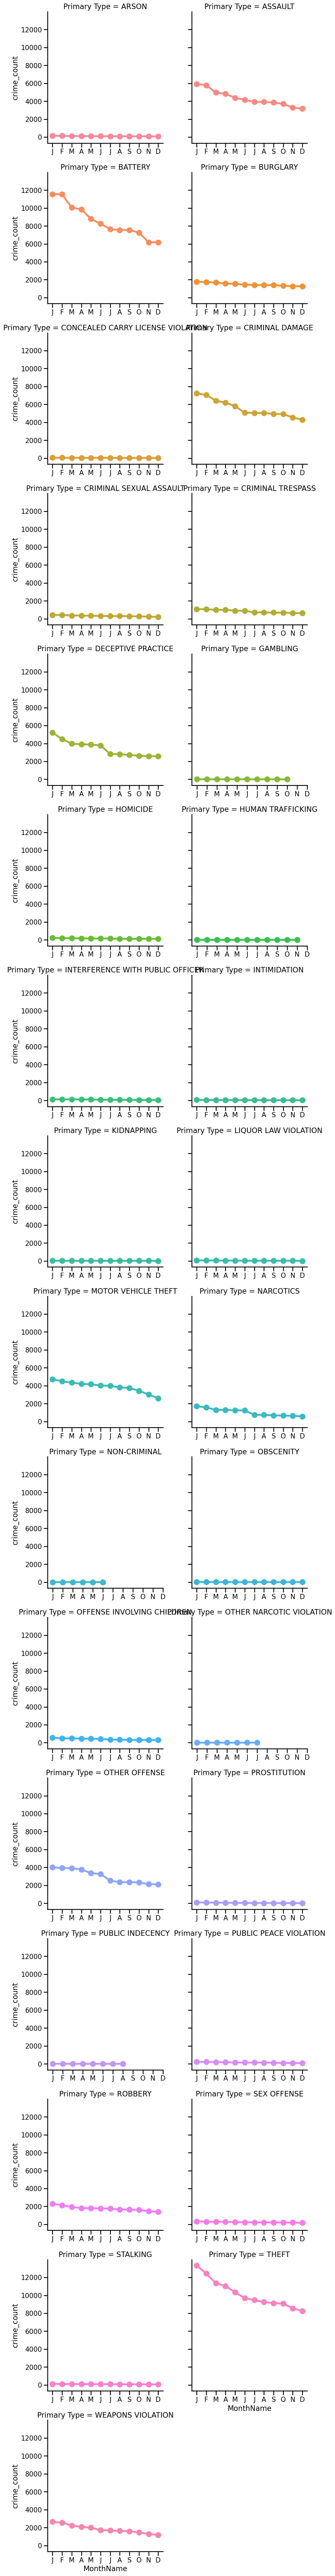

In [49]:
g = sns.catplot(data = crime_by_mos, x = 'MonthName', y = 'crime_count', hue = 'Primary Type', col = 'Primary Type',
           col_wrap= 2, kind= 'point', sharex = False, sharey = True)
g.set(xticks=np.arange(12), xticklabels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.savefig('Crime Per Month')

- Overall there is a decrease in crime over the months. Any crime that does not follow such pattern already has a low crime rate.
- Deceptive practice shows to be steady in the second quarter of the year and then drops again in June.

# Comparing Holidays:



## Are there any holidays that show an increase in the # of crimes?Are there any holidays that show a decrease in the # of crimes?

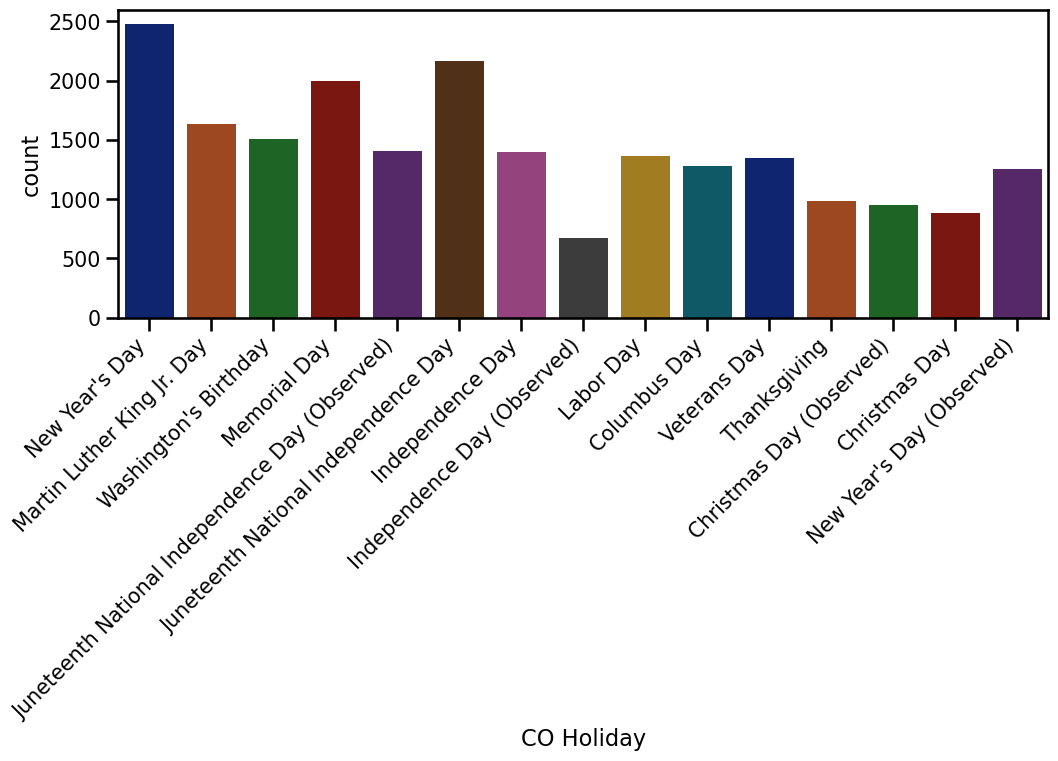

In [48]:
ax = sns.countplot(data=chicago_df, x='CO Holiday',palette='dark');
# Rotate xtick labels and align the text to the bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
plt.savefig('Data/Crime per Holiday 2021-2023.png', dpi=300, bbox_inches='tight')
plt.show()

- New Years Day has the most number of crimes in Chicago, reaching a little under 2500 in a single day.
- Independence Day (Observed) has the least amount of crimes committed. Independence day Observed it the Friday or Saturday after Independence Day, if Independence day landed on a Saturday or Sunday.

# Comparing Police Districts:



- Which district has the most crimes? Which has the least?


In [39]:
chicago_df["Primary Type"].dropna(inplace = True)


In [40]:
most_crimes = chicago_df.groupby('District')['Primary Type'].size().sort_values(ascending=False).to_frame('most crimes')
plt.savefig('Data/Most Crime')

<Figure size 1200x400 with 0 Axes>

In [41]:
most_crimes

,most crimes
District,
6.0,35908
8.0,35555
11.0,34132
4.0,33496
12.0,32679
25.0,29307
3.0,28862
1.0,28799
18.0,28621


- The District 6 police has had the most crimes between years 2021-2023.
- The District 3 police has had the least amount of crimes.
- Both of these districts are located in Illinois but District 6 is located near the southern side as District 3 is in the nothern side.